In [38]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os
import csv
from tqdm import tqdm
import pandas as pd

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split

In [39]:
output_dir = os.path.join(".", "output_jelly")  # Path to the output directory
subdirs = [f.path for f in os.scandir(output_dir) if f.is_dir()]
subdirs.sort()

# Create an empty 3D array to store the combined data
combined_arr = np.empty((len(subdirs), 1000, 10))

# Loop through each subdirectory and load the CSV files
for i, subdir in enumerate(subdirs):
    action_filename = os.path.join(subdir, "action.csv")
    obs_filename = os.path.join(subdir, "obs.csv")

    # Load the action and obs CSV files
    action_df = pd.read_csv(action_filename,  header=None)
    obs_df = pd.read_csv(obs_filename,  header=None)

    # Concatenate the DataFrames horizontally
    combined_data = pd.concat([action_df, obs_df], axis=1)

    # Convert combined_data to a 3D array and assign it to combined_arr
    combined_arr[i-1] = np.reshape(combined_data.values, (1000, 10))

# Print the shape of combined_arr
print(combined_arr.shape)
combined_tensor = torch.from_numpy(combined_arr)

(10000, 1000, 10)


# VAE code -1

# Seq2Seq

Epoch: 1, Loss: 0.0068566117627280095, Recon Loss: 0.0031653243473597934, KL Div: 0.018456436702183315
Epoch: 2, Loss: 0.005402943134307861, Recon Loss: 0.003162568245615278, KL Div: 0.011201874153954643
Epoch: 3, Loss: 0.004880710090909685, Recon Loss: 0.0031603686468941825, KL Div: 0.008601707083838327
Epoch: 4, Loss: 0.004442348650523595, Recon Loss: 0.003158445222037179, KL Div: 0.006419517091342381
Epoch: 5, Loss: 0.004145428998129709, Recon Loss: 0.003155662740979876, KL Div: 0.004948831064360482
Epoch: 6, Loss: 0.003933195897511074, Recon Loss: 0.003153860466820853, KL Div: 0.0038966770342418124
Epoch: 7, Loss: 0.0037537991489682877, Recon Loss: 0.0031516972269330706, KL Div: 0.0030105094398771015
Epoch: 8, Loss: 0.0036150205305644444, Recon Loss: 0.0031494187457220893, KL Div: 0.0023280088901519776
Epoch: 9, Loss: 0.0035021550485066005, Recon Loss: 0.003147591199193682, KL Div: 0.0017728194083486285
Epoch: 10, Loss: 0.0034098391022000995, Recon Loss: 0.0031455362354006087, KL D

Epoch: 80, Loss: 0.0029444621460778374, Recon Loss: 0.002936198830604553, KL Div: 4.1316509246826175e-05
Epoch: 81, Loss: 0.0029434124061039515, Recon Loss: 0.002936808398791722, KL Div: 3.301997269902911e-05
Epoch: 82, Loss: 0.0029363235064915247, Recon Loss: 0.002929615923336574, KL Div: 3.3537873200007846e-05
Epoch: 83, Loss: 0.0029349130392074584, Recon Loss: 0.002928616404533386, KL Div: 3.1483322381973266e-05
Epoch: 84, Loss: 0.0029318368775503975, Recon Loss: 0.0029256868873323715, KL Div: 3.075007881437029e-05
Epoch: 85, Loss: 0.0029322726726531984, Recon Loss: 0.0029264544759477888, KL Div: 2.909094520977565e-05
Epoch: 86, Loss: 0.002930730104446411, Recon Loss: 0.0029250030858176093, KL Div: 2.863500373704093e-05
Epoch: 87, Loss: 0.0029327974149159024, Recon Loss: 0.002926767706871033, KL Div: 3.0148625373840332e-05
Epoch: 88, Loss: 0.002927991850035531, Recon Loss: 0.002922474009650094, KL Div: 2.758935945374625e-05
Epoch: 89, Loss: 0.002926274538040161, Recon Loss: 0.002921

Epoch: 158, Loss: 0.002907904369490487, Recon Loss: 0.0029052514348711284, KL Div: 1.3264864683151246e-05
Epoch: 159, Loss: 0.0029054803337369645, Recon Loss: 0.0029029449735369, KL Div: 1.2676826545170376e-05
Epoch: 160, Loss: 0.002904140727860587, Recon Loss: 0.0029009740693228584, KL Div: 1.5833169221878052e-05
Epoch: 161, Loss: 0.002905418395996094, Recon Loss: 0.0029027092797415596, KL Div: 1.3545577015195575e-05
Epoch: 162, Loss: 0.0029056864636284965, Recon Loss: 0.002902323160852705, KL Div: 1.681649259158543e-05
Epoch: 163, Loss: 0.0029069569451468332, Recon Loss: 0.0029031678267887663, KL Div: 1.8945557730538503e-05
Epoch: 164, Loss: 0.002910056369645255, Recon Loss: 0.00290265417098999, KL Div: 3.701095495905195e-05
Epoch: 165, Loss: 0.002909292817115784, Recon Loss: 0.00290342036315373, KL Div: 2.9362188918249948e-05
Epoch: 166, Loss: 0.0029120147568838938, Recon Loss: 0.0029019409077508107, KL Div: 5.0369139228548326e-05
Epoch: 167, Loss: 0.002912779416356768, Recon Loss: 

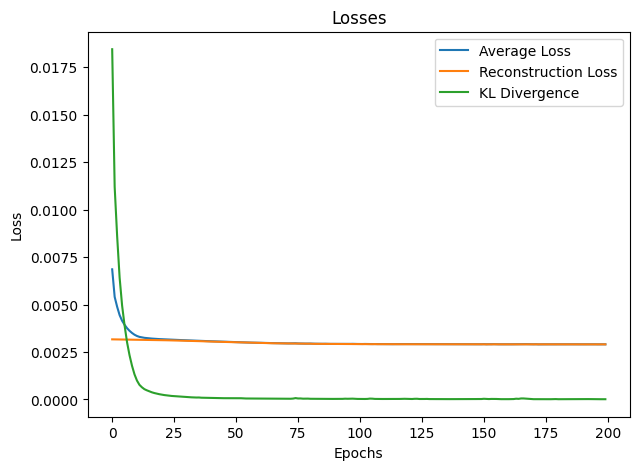

In [40]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

class Encoder(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_shape, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, latent_dim * 2)
        )

    def forward(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=1)
        return mu, log_var, h

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_shape):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, output_shape),
        )

    def forward(self, z):
        x_reconstructed = self.decoder(z)
        return x_reconstructed
    
class PredictorDecoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_shape):
        super(PredictorDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim3),
            nn.ReLU(),
            nn.Linear(hidden_dim3, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, output_shape),
        )

    def forward(self, z):
        next_action_predicted = self.decoder(z)
        return next_action_predicted


class VAE(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, input_shape)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var, h = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, mu, log_var    

class ActionPredictingVAE(nn.Module):
    def __init__(self, input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim):
        super(ActionPredictingVAE, self).__init__()
        self.encoder = Encoder(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)
        self.decoder = PredictorDecoder(latent_dim, hidden_dim1, hidden_dim2, hidden_dim3, input_shape)

    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var / 2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var, _ = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        next_action_predicted = self.decoder(z)
        return next_action_predicted, mu, log_var

        
# Assuming combined_tensor is your data
data_tensor = combined_tensor.float()
input_tensor = data_tensor[:, :-1, :]  # All except the last sequence
target_tensor = data_tensor[:, 1:, :]  # All except the first sequence
input_tensor = input_tensor.view(input_tensor.size(0), -1)
target_tensor = target_tensor.view(target_tensor.size(0), -1)

batch_size = 512
dataset = TensorDataset(input_tensor, target_tensor)
train_size = int(0.7 * len(dataset))
valid_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

input_shape = input_tensor.shape[1]
hidden_dim1 = 24
hidden_dim2 = 12
hidden_dim3 = 12
latent_dim = 2
lr = 5e-5
n_epochs = 200
beta = 0.2


# model = VAE(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)
model = ActionPredictingVAE(input_shape, hidden_dim1, hidden_dim2, hidden_dim3, latent_dim)

optimizer = optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

def train(epoch, model, optimizer, loss_fn, train_loader):
    model.train()
    train_loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    for i, batch in enumerate(train_loader):
        batch_data, target_data = batch
        optimizer.zero_grad()
        reconstructed_batch, mu, log_var = model(batch_data)
        recon_loss = loss_fn(reconstructed_batch, target_data)
        kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        loss = recon_loss + beta*kl_divergence
        loss.backward()
        train_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_div += kl_divergence.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = total_recon_loss / len(train_loader.dataset)
    avg_kl_div = total_kl_div / len(train_loader.dataset)
    print(f'Epoch: {epoch}, Loss: {avg_loss}, Recon Loss: {avg_recon_loss}, KL Div: {avg_kl_div}')

    return avg_loss, avg_recon_loss, avg_kl_div

avg_losses = []
avg_recon_losses = []
avg_kl_divs = []
for epoch in range(1, n_epochs + 1):
    avg_loss, avg_recon_loss, avg_kl_div = train(epoch, model, optimizer, loss_fn, train_loader)
    avg_losses.append(avg_loss)
    avg_recon_losses.append(avg_recon_loss)
    avg_kl_divs.append(avg_kl_div)

plt.figure(figsize=(7,5))
plt.plot(avg_losses, label='Average Loss')
plt.plot(avg_recon_losses, label='Reconstruction Loss')
plt.plot(avg_kl_divs, label='KL Divergence')
plt.title('Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [41]:
def evaluate(model, loss_fn, dataloader):
    model.eval()
    loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            batch_data = batch[0]  # get the data from the batch

            # Flatten the data
            batch_data = batch_data.view(batch_data.size(0), -1)

            reconstructed_batch, mu, log_var = model(batch_data)

            # Loss: reconstruction loss + KL divergence
            recon_loss = loss_fn(reconstructed_batch, batch_data)
            kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss += recon_loss + kl_divergence
            total_recon_loss += recon_loss.item()
            total_kl_div += kl_divergence.item()

    avg_loss = loss / len(dataloader.dataset)
    avg_recon_loss = total_recon_loss / len(dataloader.dataset)
    avg_kl_div = total_kl_div / len(dataloader.dataset)

    return avg_loss, avg_recon_loss, avg_kl_div
evaluate(model, loss_fn, test_loader)

(tensor(0.0029), 0.002932112773259481, 1.306082804997762e-05)

# latent space plot

In [42]:
# 예측할 action_t 샘플을 선택 (예: 테스트 데이터셋의 첫 번째 배치)
sample_action_t = next(iter(test_loader))[0][0].unsqueeze(0)  # 첫 번째 배치에서 첫 번째 샘플 선택

# 모델을 평가 모드로 설정
model.eval()

# 예측 수행 (재구성 손실 및 KL 발산은 여기서 무시)
with torch.no_grad():
    reconstructed_action_t1, _, _ = model(sample_action_t)

# reconstructed_action_t1은 action_t+1의 예측값입니다.
# 필요한 경우 이 값을 numpy 배열로 변환하거나 다른 형태로 가공할 수 있습니다.
predicted_action_t1 = reconstructed_action_t1.numpy()  # 예: numpy 배열로 변환


In [43]:
import pandas as pd

def test_model(model, test_loader):
    model.eval()
    all_original_t1 = []
    all_predicted_t1 = []
    
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            batch_data, target_data = batch
            
            # Flatten the data if needed
            batch_data = batch_data.view(batch_data.size(0), -1)
            target_data = target_data.view(target_data.size(0), -1)

            reconstructed_batch, _, _ = model(batch_data)  # Predict action_{t+1}

            # Convert tensors to numpy arrays
            original_t1 = target_data.detach().cpu().numpy()
            predicted_t1 = reconstructed_batch.detach().cpu().numpy()

            all_original_t1.append(original_t1)
            all_predicted_t1.append(predicted_t1)

    # Convert to dataframes
    original_df = pd.DataFrame(np.vstack(all_original_t1))
    reconstructed_df = pd.DataFrame(np.vstack(all_predicted_t1))

    return original_df, reconstructed_df

# Assuming the test_loader contains pairs of (action_t, action_t+1)
original_df, reconstructed_df = test_model(model, test_loader)


# render with action

In [44]:

import torch

# Convert combined_arr to PyTorch Tensor
# combined_tensor = torch.from_numpy(combined_arr)

# Print the shape of combined_tensor
print(combined_tensor.shape)

import matplotlib.pyplot as plt
from IPython import display
import gym


def replay(combined_data):

    action_sp = combined_data.iloc[:, :2]
    obs_sp = combined_data.iloc[:, 2:]

    env = gym.make('Swimmer-v4', render_mode = 'human')

    # Iterate through the rows
    for i in range(len(action_sp)):
        # Get the i-th row
        action = action_sp.iloc[i]
        observation = obs_sp.iloc[i]
#         print(action)

        # If this is the first iteration, set the environment state to the given observation
        # Note: This assumes that the observation you've stored is the entire state that can be set with `env.reset()`
        # If this is not the case, you cannot simply set the environment state to the observation
        if i == 0:
            env.reset()  # We ignore the initial observation returned by `reset`

        # Apply the action
        next_observation, reward, done, trunc, info = env.step(action)
        # Render the environment
        env.render()
        # If you want to slow down each step for viewing, you can use time.sleep
        # time.sleep(0.01)

    # Close the environment
    env.close()


torch.Size([10000, 1000, 10])


# render with action save

In [45]:
from gym import wrappers
from gym.wrappers.monitoring.video_recorder import VideoRecorder

def replay_save(combined_data):
    action_sp = combined_data.iloc[:, :2]
    obs_sp = combined_data.iloc[:, 2:]

    env = gym.make('Swimmer-v4', render_mode = 'human')
    outputvid_dir = os.path.join(".", "video", "video.mp4")
    print(outputvid_dir)
    vid_recorder = VideoRecorder(env=env, path=outputvid_dir ,enabled=True)
#     vid_recorder = VideoRecorder(env, path=outputvid_dir) # Video file path
    
    # Iterate through the rows
    for i in range(len(action_sp)):
        action = action_sp.iloc[i]

        if i == 0:
            env.reset()

        # Apply the action
        next_observation, reward, done, trunc, info = env.step(action)
        
        # Render the environment
        env.render()

        # Capture frame for video
        vid_recorder.capture_frame()
#         print('video saved')

    # Close the environment and video recorder
    vid_recorder.close()
    env.close()

# see the output

In [46]:
def test_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            batch_data = batch[0]  # get the data from the batch
            batch_data = batch_data.view(batch_data.size(0), -1)  # flatten the data
            reconstructed_batch, _, _ = model(batch_data)  # get reconstructed data from the model

            # Convert tensors to numpy arrays for use in pandas
            original_data = batch_data.detach().cpu().numpy()
            reconstructed_data = reconstructed_batch.detach().cpu().numpy()

            # Convert to dataframes
            original_df = pd.DataFrame(original_data)
            reconstructed_df = pd.DataFrame(reconstructed_data)

            if i == 0:  # for the first iteration, create the dataframes
                all_original_df = original_df
                all_reconstructed_df = reconstructed_df
            else:  # for subsequent iterations, append to the existing dataframes
                all_original_df = pd.concat([all_original_df, original_df])
                all_reconstructed_df = pd.concat([all_reconstructed_df, reconstructed_df])
    
    return all_original_df, all_reconstructed_df

# Call the function after training
original_df, reconstructed_df = test_model(model, test_loader)


In [47]:
original_df

,0,1,2,3,4,5,6,7,8,9,...,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989
0,-0.562055,-0.581112,0.098240,0.015230,0.069783,0.077697,-0.327444,0.469111,-0.366936,-0.460053,...,-0.981355,-0.706471,-1.145481,1.095615,1.440931,-0.423414,-0.548565,1.166592,-1.746191,-0.688885
1,0.998714,0.016582,-0.109167,0.043794,0.082657,0.104528,0.732830,-0.860177,0.851958,0.863206,...,-0.999412,0.710319,0.381209,-0.836224,0.001226,0.854756,-1.596591,2.264229,-1.730403,-3.165979
2,-0.307196,0.780177,-0.020136,-0.065374,0.080962,-0.052377,-0.284845,0.240974,-0.274745,-0.245177,...,-0.303106,-0.165744,1.353323,-1.280080,-1.418529,0.299027,0.067292,0.283048,0.208749,-0.573214
3,0.961832,0.919806,-0.085223,0.038937,0.117295,-0.008452,0.585383,-0.800488,0.835721,0.858643,...,0.988984,0.057846,1.304888,-1.102158,-1.435054,-0.491194,0.480619,-1.160445,1.743300,0.697783
4,0.993468,-0.636397,-0.032732,-0.013445,-0.006460,0.057906,0.729208,-0.791894,0.801760,0.786361,...,0.982633,-0.394849,0.133119,0.310153,-0.614722,0.158428,2.111220,-2.408173,2.491524,2.544671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,0.816456,-0.695703,0.076417,0.111375,0.092711,-0.151295,0.621817,-0.556935,0.636361,0.683055,...,0.515209,-0.272161,1.443646,-1.259237,-1.456403,0.128288,0.135180,-0.011885,0.502199,-0.280468
472,0.999680,0.915057,-0.064332,-0.073978,0.105734,0.063054,0.701603,-0.822794,0.744110,0.915273,...,-0.994014,-0.062646,-0.068697,-0.431316,0.597753,0.265299,-2.112828,2.423922,-2.423636,-2.690194
473,0.999932,0.054203,0.014717,0.022666,-0.018855,0.004149,0.716859,-0.880177,0.777984,0.851482,...,-0.166305,-0.158048,1.358613,-1.270550,-1.431286,0.267806,0.075932,0.230893,0.251606,-0.512758
474,0.997809,0.404582,-0.029180,0.092479,-0.053238,0.062332,0.741533,-0.798117,0.806667,0.785776,...,0.017194,-0.630767,-1.289458,1.302601,1.392809,0.294876,-0.051428,-0.264494,-0.259228,0.600753


In [48]:
reconstructed_df

,0,1,2,3,4,5,6,7,8,9,...,9980,9981,9982,9983,9984,9985,9986,9987,9988,9989
0,0.594225,0.293523,-0.031521,0.028451,0.033991,0.017493,0.690269,-0.614828,0.813621,0.842521,...,0.194042,-0.178524,-0.017662,-0.012485,-0.017939,0.010567,0.005734,-0.003648,-0.002509,0.001399
1,0.571462,0.301944,-0.038757,0.048806,0.032148,0.029988,0.633379,-0.575876,0.733535,0.803315,...,0.167379,-0.193447,-0.005474,-0.009194,-0.010600,0.002450,-0.008021,0.006011,-0.006052,0.004068
2,0.560671,0.271741,-0.028283,0.038965,0.030037,0.013482,0.646308,-0.556594,0.752366,0.791937,...,0.179799,-0.186645,-0.014498,-0.017108,-0.025908,0.013189,0.001723,0.001818,-0.007587,0.001972
3,0.721578,0.367116,-0.052100,0.011434,0.044554,0.067180,0.817111,-0.823191,1.025396,0.993873,...,0.234943,-0.197846,0.019343,0.016136,0.029743,-0.021179,0.002720,0.001303,0.004745,-0.017338
4,0.626478,0.320941,-0.046606,0.012425,0.042252,0.038276,0.748881,-0.702434,0.911972,0.893192,...,0.219323,-0.181675,-0.010065,-0.004452,0.005160,-0.007511,0.000263,0.001853,0.005144,-0.006736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,0.547450,0.260000,-0.023217,0.040000,0.032250,0.016232,0.649546,-0.562057,0.759332,0.804338,...,0.177224,-0.195304,-0.010585,-0.016316,-0.020568,0.009767,-0.004562,0.001648,-0.008890,0.005648
472,0.654368,0.318512,-0.037730,0.040188,0.047321,0.053510,0.697600,-0.703256,0.869022,0.946178,...,0.180127,-0.217653,0.014485,0.007928,0.019124,-0.004896,-0.003558,0.002001,0.002373,-0.000353
473,0.585366,0.304556,-0.039796,0.018463,0.036461,0.021468,0.703102,-0.630481,0.834465,0.839026,...,0.204434,-0.172888,-0.020683,-0.014046,-0.010063,0.000767,0.001505,-0.001599,-0.001787,-0.002540
474,0.636817,0.310962,-0.030943,0.023537,0.038874,0.024515,0.734993,-0.678396,0.883325,0.912041,...,0.201839,-0.184618,-0.011512,-0.005779,-0.003337,0.006359,0.007845,-0.007544,-0.004226,0.002121


In [49]:
# Get the first row from the dataframe
first_row_reco = reconstructed_df.iloc[0]

# Reshape it to (1000, 10)
reshaped_reco_array = np.reshape(first_row_reco.values, (999, 10))

# Convert it back to a dataframe
reshaped_df_reco = pd.DataFrame(reshaped_reco_array)
recon_combined_tensor = torch.tensor(reshaped_df_reco.values)


In [50]:
reshaped_df_reco

,0,1,2,3,4,5,6,7,8,9
0,0.594225,0.293523,-0.031521,0.028451,0.033991,0.017493,0.690269,-0.614828,0.813621,0.842521
1,0.587499,0.270302,-0.069005,0.077765,0.065941,0.086495,0.876791,-1.057824,1.038746,0.974690
2,0.535458,-0.300916,-0.125777,0.118740,0.109467,0.158152,0.951811,-1.072945,0.867191,1.119317
3,0.549048,-0.306122,-0.169192,0.178360,0.174453,0.244281,0.869140,-1.101374,1.202531,1.269506
4,0.534878,-0.214389,-0.208812,0.206912,0.229600,0.291613,0.908916,-1.078389,1.068535,1.258521
...,...,...,...,...,...,...,...,...,...,...
994,0.137557,-0.159661,0.281133,-0.222602,-0.311366,0.172412,0.162423,-0.151586,0.300587,0.042866
995,0.167085,-0.188432,0.289636,-0.206422,-0.291471,0.178783,0.157972,-0.186359,0.345619,0.054025
996,0.149263,-0.172446,0.291942,-0.194885,-0.321143,0.170537,0.190064,-0.224945,0.385876,0.122399
997,0.171492,-0.185315,0.260456,-0.191968,-0.312858,0.171388,0.229796,-0.265185,0.381476,0.156090


In [51]:
replay(reshaped_df_reco)

/opt/homebrew/Caskroom/miniconda/base/envs/firstenv/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [52]:
replay_save(reshaped_df_reco)

./video/video.mp4


/opt/homebrew/Caskroom/miniconda/base/envs/firstenv/lib/python3.11/site-packages/gym/wrappers/monitoring/video_recorder.py:59: UserWarning: WARN: Disabling video recorder because environment <TimeLimit<OrderEnforcing<PassiveEnvChecker<SwimmerEnv<Swimmer-v4>>>>> was not initialized with any compatible video mode between `rgb_array` and `rgb_array_list`
  logger.warn(


In [53]:
# Get the first row from the dataframe
first_row_ori = original_df.iloc[0]

# Reshape it to (1000, 10)
reshaped_array_ori = np.reshape(first_row_ori.values, (999, 10))

# Convert it back to a dataframe
reshaped_df_ori = pd.DataFrame(reshaped_array_ori)
ori_combined_tensor = torch.tensor(reshaped_df_ori.values)


In [54]:
ori_combined_tensor[0]

tensor([-0.5621, -0.5811,  0.0982,  0.0152,  0.0698,  0.0777, -0.3274,  0.4691,
        -0.3669, -0.4601])

In [55]:
replay(reshaped_df_ori)

In [56]:
# Flatten the tensors
flattened_ori = ori_combined_tensor.flatten()
flattened_recon = recon_combined_tensor.flatten()

# Calculate the Euclidean distance
euclidean_distance = torch.norm(flattened_ori - flattened_recon)


print(euclidean_distance)


tensor(150.1057)


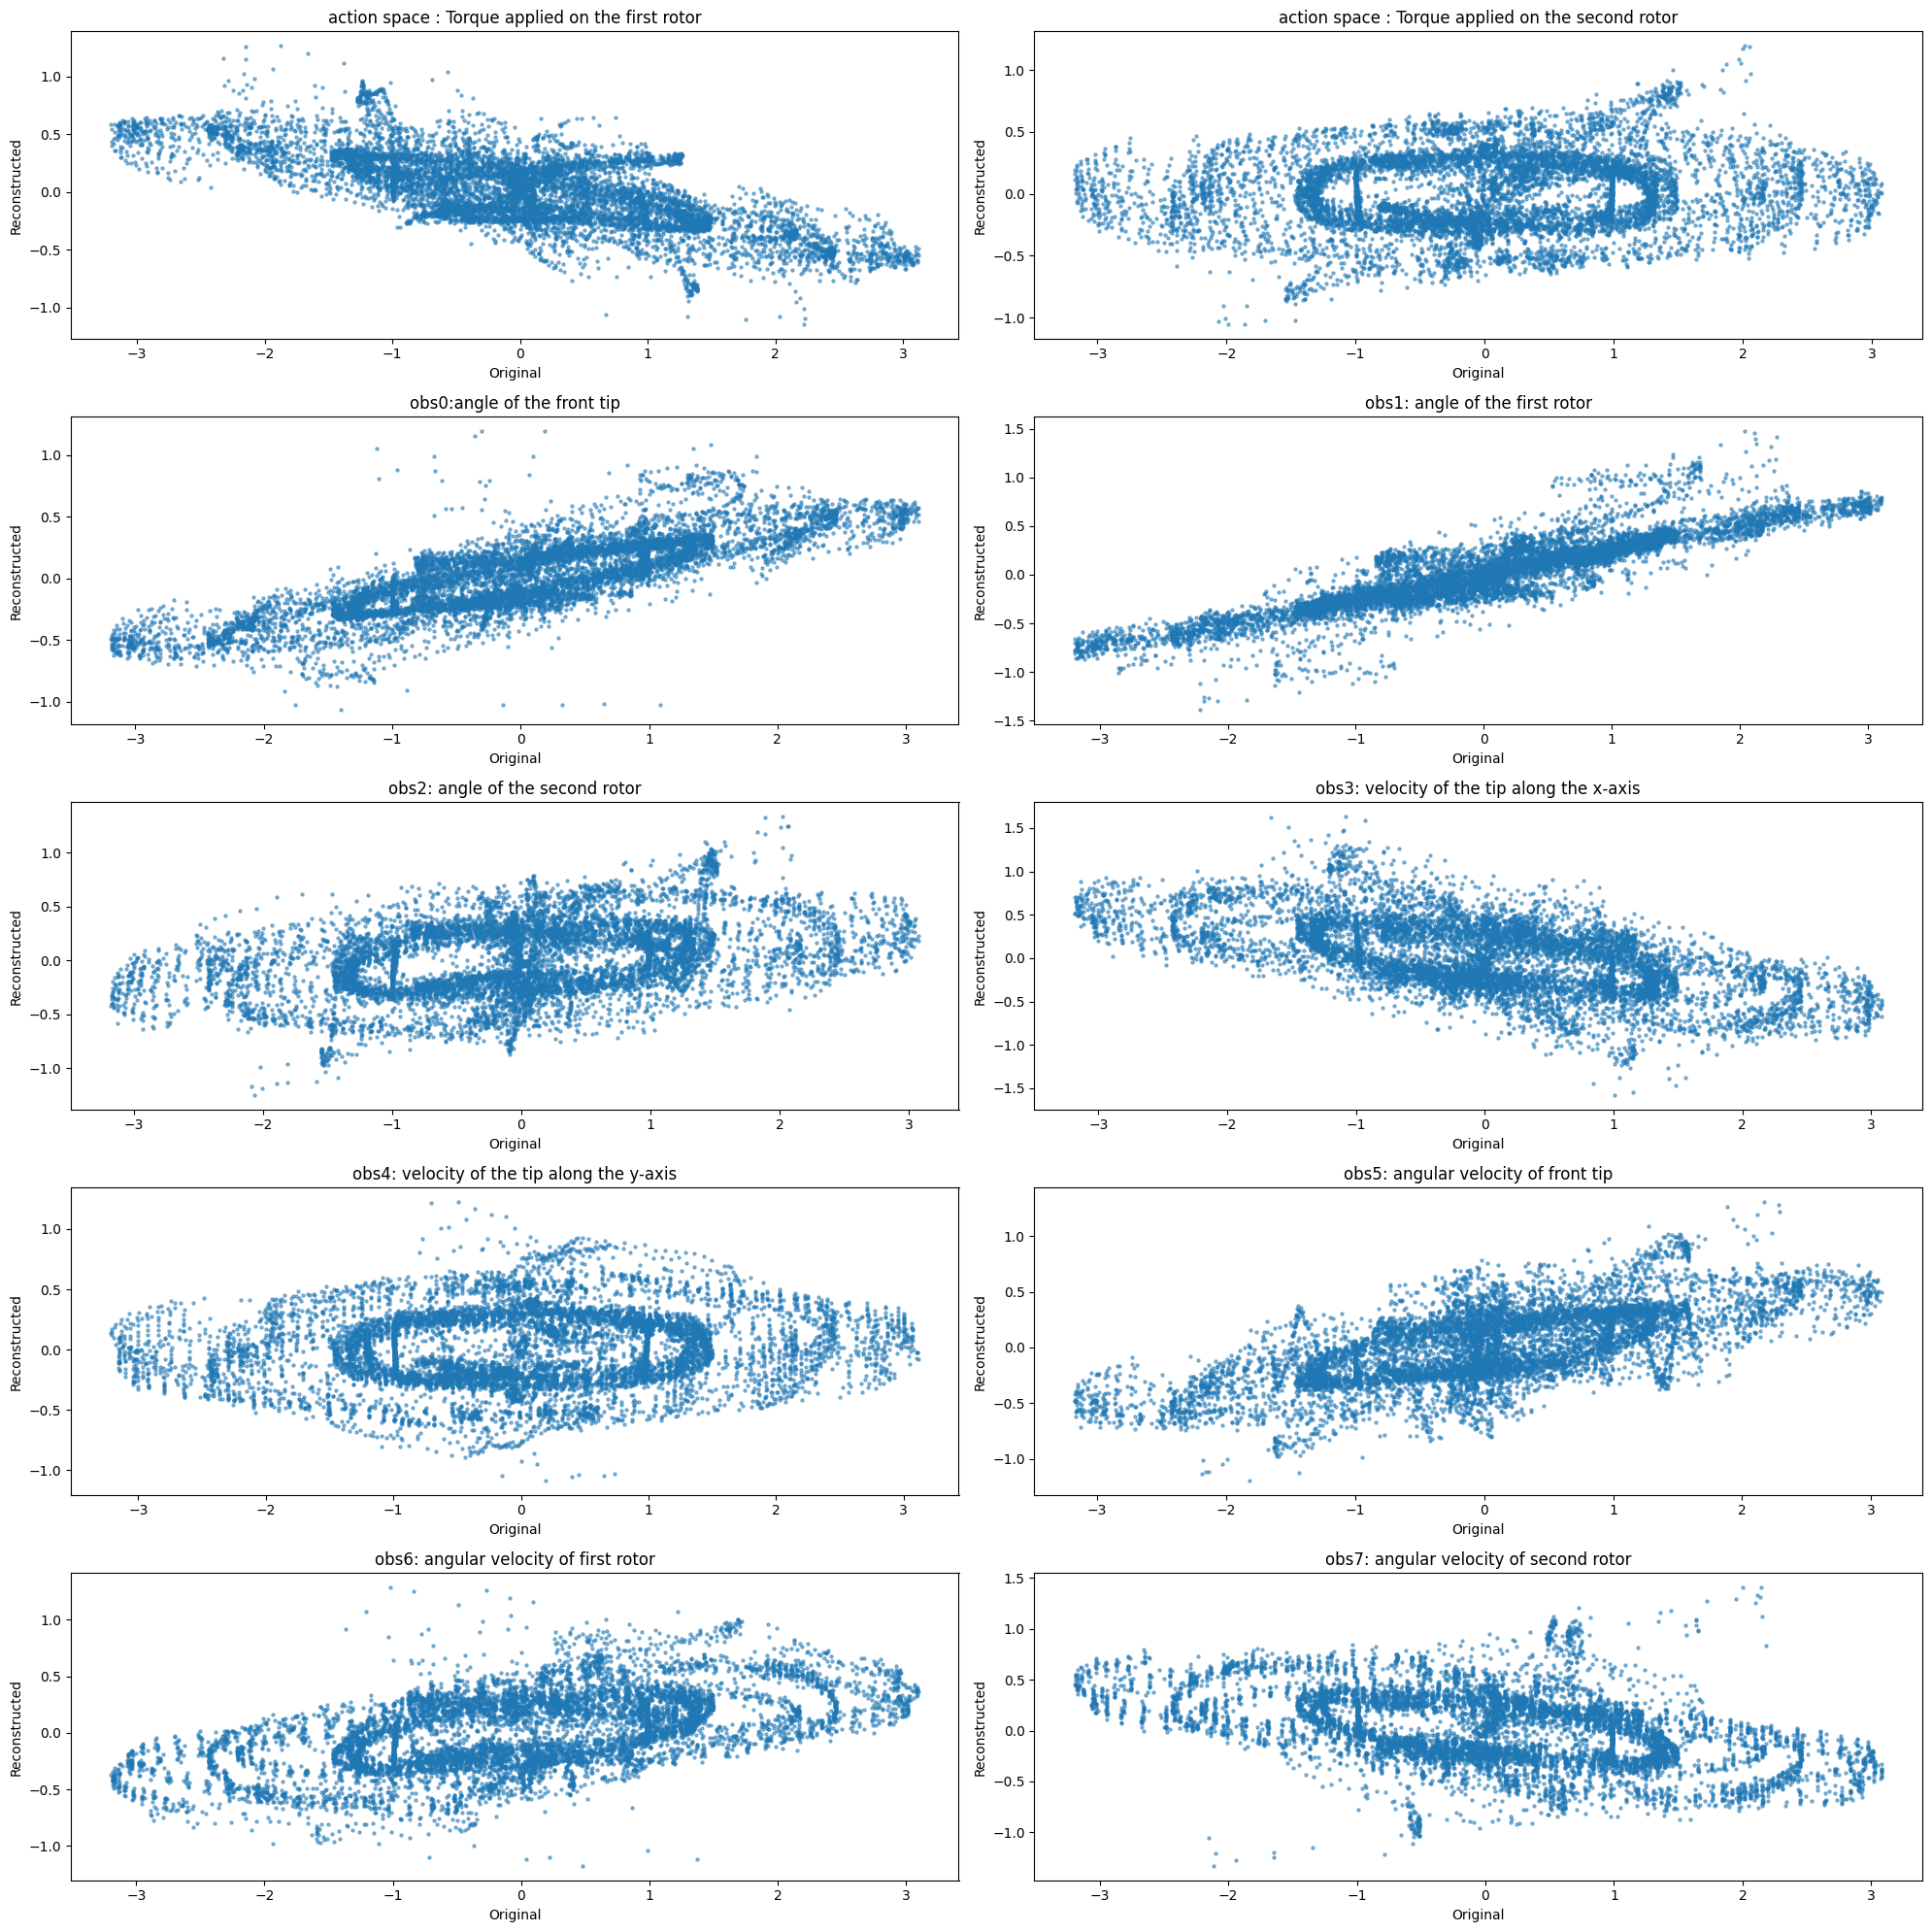

In [57]:
ori_combined_np = original_df.to_numpy()
recon_combined_np = reconstructed_df.to_numpy()

# Column names
column_names = ['action space : Torque applied on the first rotor', 
                'action space : Torque applied on the second rotor', 
                'obs0:angle of the front tip', 'obs1: angle of the first rotor', 
                'obs2: angle of the second rotor', 'obs3: velocity of the tip along the x-axis',
                'obs4: velocity of the tip along the y-axis', 'obs5: angular velocity of front tip',
                'obs6: angular velocity of first rotor', 'obs7: angular velocity of second rotor']

# Create a figure
plt.figure(figsize=(20, 20))

# Create subplots for each column
for i in range(10):  # Assuming you have 10 columns
    plt.subplot(5, 2, i+1)  # 5 rows and 2 columns of subplots
    plt.scatter(ori_combined_np[i, :], recon_combined_np[i, :], alpha=0.5, s=5)
    plt.title(column_names[i])
    plt.xlabel('Original')
    plt.ylabel('Reconstructed')

# Display the plot
plt.tight_layout()
plt.show()


In [58]:
ori_combined_np.shape

(1500, 9990)

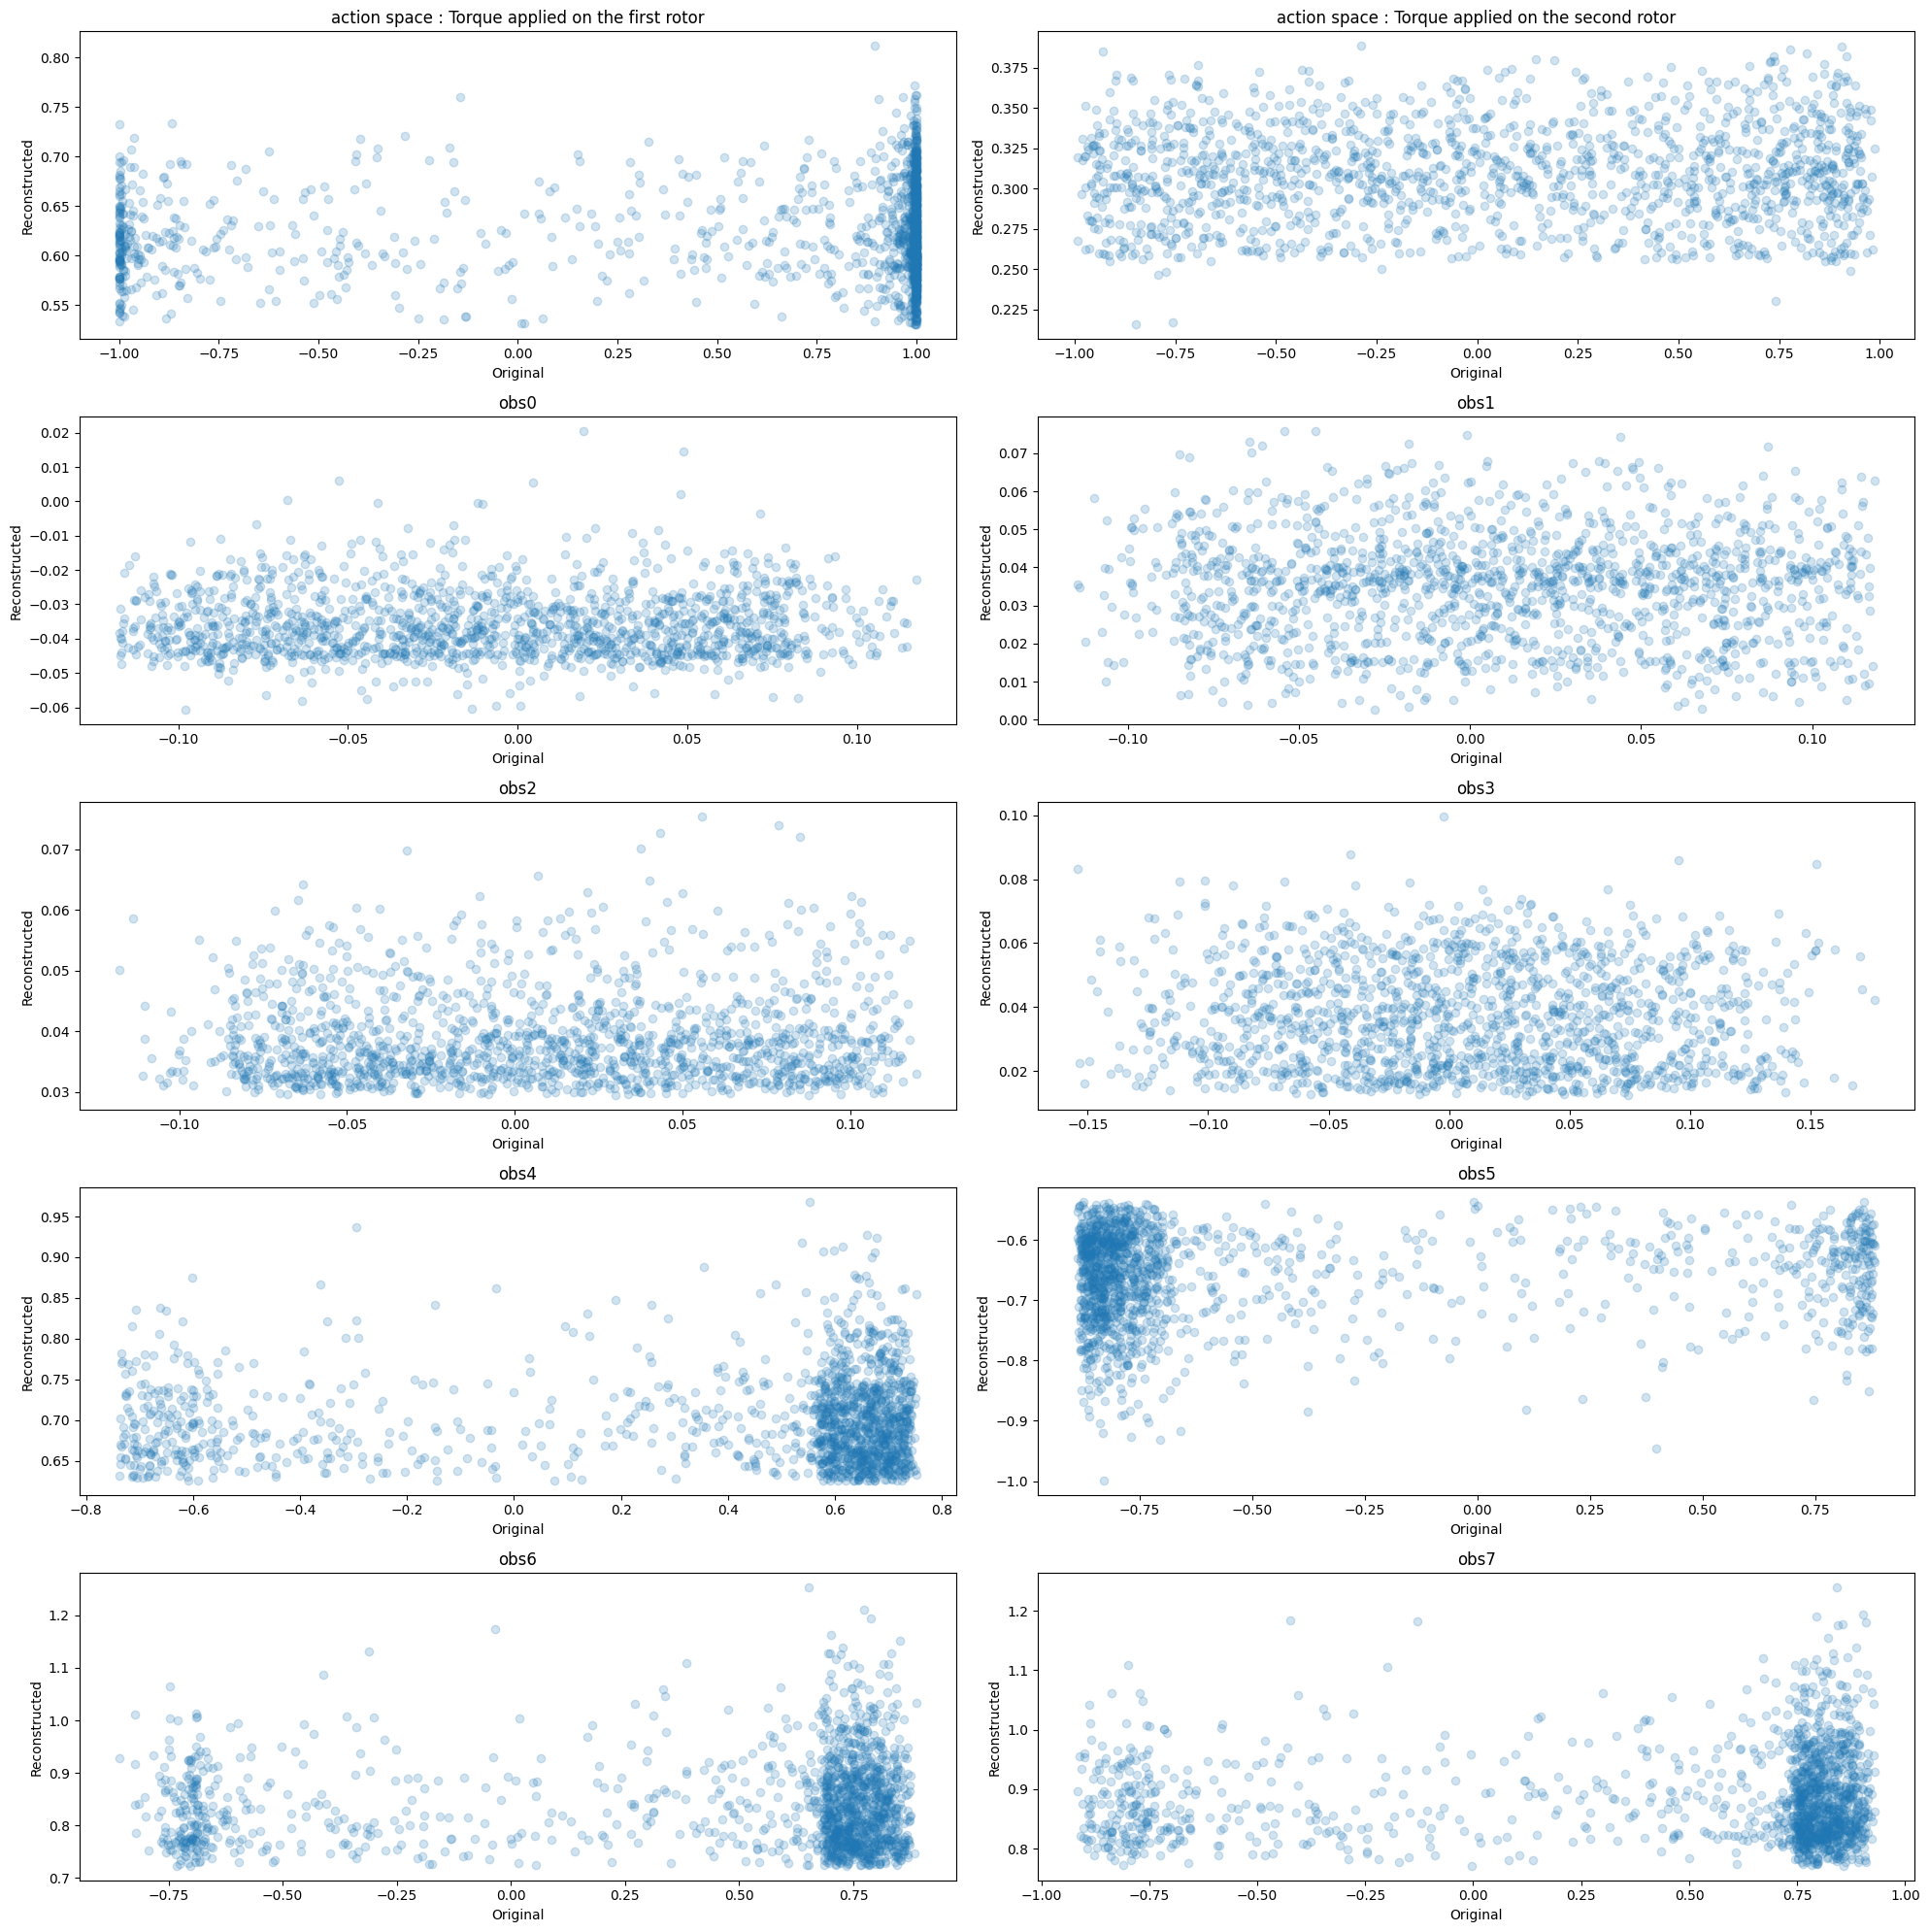

In [59]:
# Column names
column_names = ['action space : Torque applied on the first rotor', 
                'action space : Torque applied on the second rotor', 
                'obs0', 'obs1', 'obs2', 'obs3', 'obs4', 'obs5', 'obs6', 'obs7']

# Create a figure
plt.figure(figsize=(20, 20))

# Create subplots for each column
for i in range(10):  # Assuming you have 10 columns
    plt.subplot(5, 2, i+1)  # 5 rows and 2 columns of subplots
    plt.scatter(ori_combined_np[:, i], recon_combined_np[:, i], alpha=0.2)
    plt.title(column_names[i])
    plt.xlabel('Original')
    plt.ylabel('Reconstructed')

# Display the plot
plt.tight_layout()
plt.show()


In [60]:
# Test

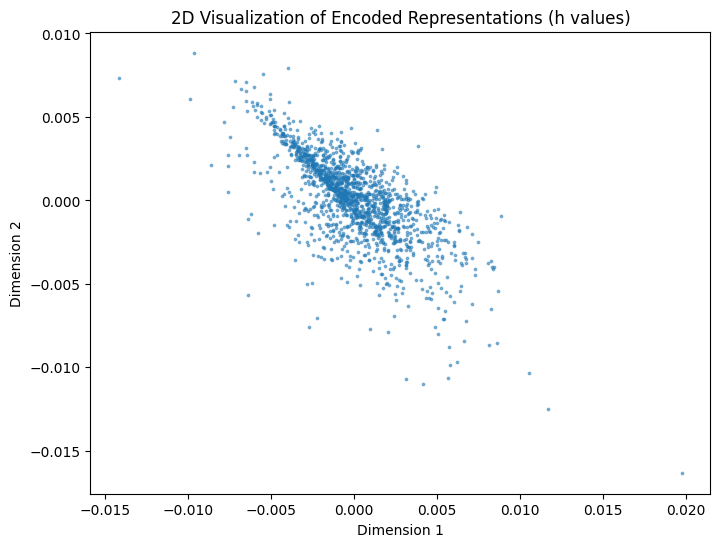

In [61]:
# Get encoded representations (h values) for all data points
encoded_representations = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch_data = batch[0]
        batch_data = batch_data.view(batch_data.size(0), -1)
        batch_data = batch_data.float()
        _, _, h = model.encoder(batch_data)  # Get the encoded representation (h value) directly
        encoded_representations.append(h)

encoded_representations = torch.cat(encoded_representations, dim=0).numpy()

# Assuming the encoded representations are 2D, plot the data in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(encoded_representations[:, 0], encoded_representations[:, 1], alpha=0.5, s=3)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Visualization of Encoded Representations (h values)')
plt.show()


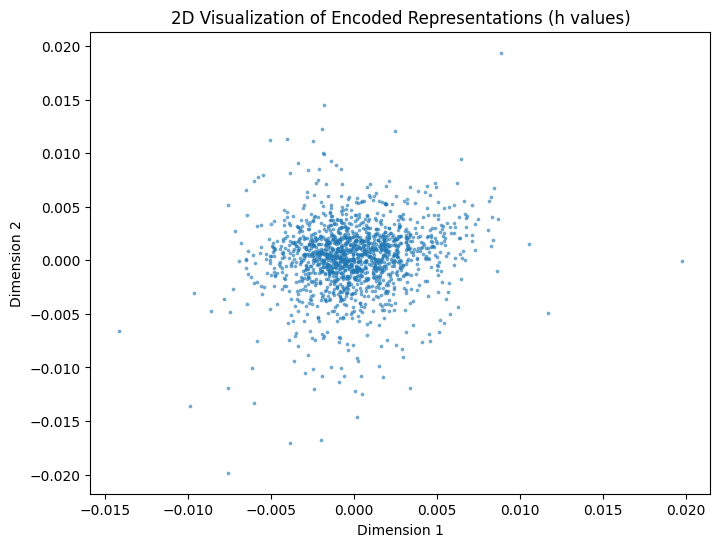

In [62]:
# Get encoded representations (h values) for all data points
encoded_representations = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        batch_data = batch[0]
        batch_data = batch_data.view(batch_data.size(0), -1)
        batch_data = batch_data.float()
        _, _, h = model.encoder(batch_data)  # Get the encoded representation (h value) directly
        encoded_representations.append(h)

encoded_representations = torch.cat(encoded_representations, dim=0).numpy()

# Assuming the encoded representations are 2D, plot the data in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(encoded_representations[:, 0], encoded_representations[:, 2], alpha=0.5, s=3)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2D Visualization of Encoded Representations (h values)')
plt.show()


In [63]:
model.eval()  # Evaluation mode
total_loss = 0
with torch.no_grad():
    for batch_data, target_data in test_loader:
        predicted_next_actions, _, _ = model(batch_data)
        loss = loss_fn(predicted_next_actions, target_data)  # Compare predicted T+1 with actual T+1
        total_loss += loss.item()

average_loss = total_loss / len(test_loader)
print(f'Mean Squared Error on Test Data: {average_loss}')


Mean Squared Error on Test Data: 1.4623918135960896
